###Inventory Management System for Small Retailers
###By Gargee Meshram

# System Overview
The **Inventory Management System (IMS)** provides a user-friendly platform for small retailers to manage stock levels, ensure timely restocking, and leverage data analytics for demand forecasting. The system integrates with point-of-sale (POS) systems and uses machine learning for predictive analytics.

## Architecture Components

### Frontend (User Interface)
- **Web Application**: A responsive web app built with **React.js**, offering an intuitive interface for managing inventory, viewing sales reports, and setting up automatic reordering.
- **Mobile Application** (Optional): Developed using frameworks like **React Native** to provide mobile access.

### Backend
- **API Server**: A **RESTful API** built with **Node.js** and **Express.js** that handles frontend requests, manages inventory data, and connects with the database and predictive models.
- **Database**: A NoSQL database such as **MongoDB** to store inventory data, sales records, user details, and other essential information.

### Predictive Analytics Engine
- **Machine Learning Module**: Implemented in **Python** using libraries like **Statsmodels** and **Scikit-learn** to analyze historical sales data, develop predictive models (e.g., **ARIMA**), and generate forecasts.
- **Scheduler**: A tool like **cron** to run prediction models periodically and update forecast data.

### Notification Service
- **Alert System**: A service to send notifications (via email or SMS) when stock levels are low or automatic reordering is triggered.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Setup for data generation
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 6, 30)
days_count = (end_date - start_date).days + 1
total_products = 5  # Number of distinct products

# Generate the date range
date_list = [start_date + timedelta(days=x) for x in range(days_count)]

# Initialize data list for synthetic sales data
records = []
np.random.seed(42)  # Ensures repeatable results

for item_id in range(1, total_products + 1):
    # Randomly generate sales quantity for each product
    sales_quantity = np.random.poisson(lam=28, size=days_count) + np.random.randint(5, 20, size=days_count)

    for date, quantity in zip(date_list, sales_quantity):
        records.append([item_id, date, quantity])

# Create DataFrame from generated data
sales_df = pd.DataFrame(records, columns=['product_id', 'date', 'quantity_sold'])

# Optionally save DataFrame to CSV
sales_df.to_csv('inventory_sales_data.csv', index=False)

# Display the first few rows to verify data
print(sales_df.head())



   product_id       date  quantity_sold
0           1 2024-01-01             41
1           1 2024-01-02             46
2           1 2024-01-03             36
3           1 2024-01-04             37
4           1 2024-01-05             45


Forecasted Sales:
 2024-06-01    32.735534
2024-06-02    36.006522
2024-06-03    34.701127
2024-06-04    32.972290
2024-06-05    32.546857
2024-06-06    32.665695
2024-06-07    33.481703
2024-06-08    33.580023
2024-06-09    33.314216
2024-06-10    33.197305
2024-06-11    33.141365
2024-06-12    33.226484
2024-06-13    33.303475
2024-06-14    33.277069
2024-06-15    33.255048
2024-06-16    33.240559
2024-06-17    33.240661
2024-06-18    33.256528
2024-06-19    33.258430
2024-06-20    33.254685
2024-06-21    33.252660
2024-06-22    33.250781
2024-06-23    33.252452
2024-06-24    33.253853
2024-06-25    33.253453
2024-06-26    33.253204
2024-06-27    33.252826
2024-06-28    33.252792
2024-06-29    33.253098
2024-06-30    33.253122
Freq: D, Name: predicted_mean, dtype: float64
Mean Squared Error (MSE): 94.07


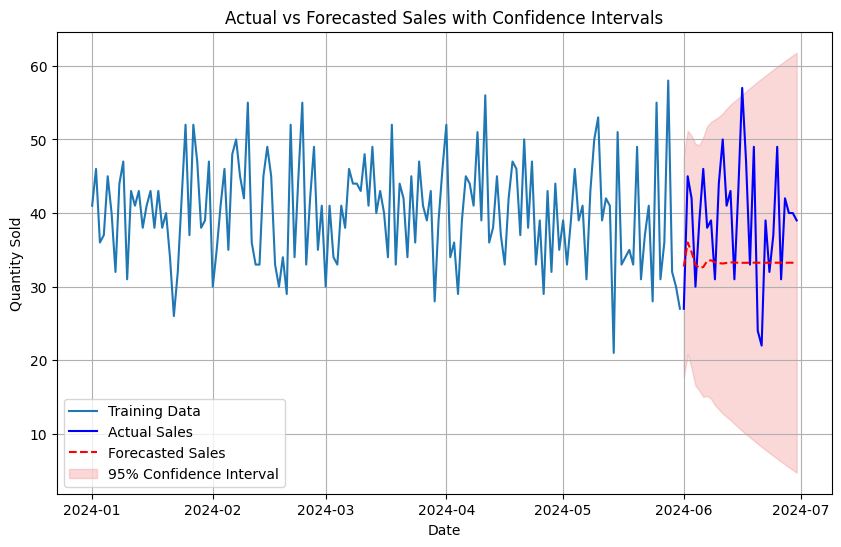

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('inventory_sales_data.csv', parse_dates=['date'])

# Ensure date column is datetime format and set it as index for time series analysis
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Isolate sales data for a single product (e.g., product_id = 1)
single_product_sales = data[data['product_id'] == 1]['quantity_sold']

# Resample to daily frequency, forward-fill any missing dates
single_product_sales = single_product_sales.asfreq('D').ffill()

# Split data for training and evaluation
train_series = single_product_sales[:-30]  # Train on most of the dataset
test_series = single_product_sales[-30:]   # Use last 30 days for testing

# Define and fit ARIMA model
arima_model = ARIMA(train_series, order=(5, 1, 0))  # Parameters (p, d, q) can be adjusted as needed
fitted_model = arima_model.fit()

# Forecast with confidence intervals
forecast_result = fitted_model.get_forecast(steps=len(test_series))
predicted_sales = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Display forecast results
print("Forecasted Sales:\n", predicted_sales)

# Calculate mean squared error for model evaluation
mse = mean_squared_error(test_series, predicted_sales)
print(f'Mean Squared Error (MSE): {mse:.2f}')

# Plot actual vs predicted values, including confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(train_series, label='Training Data')
plt.plot(test_series, label='Actual Sales', color='blue')
plt.plot(test_series.index, predicted_sales, label='Forecasted Sales', color='red', linestyle='--')
plt.fill_between(test_series.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='lightcoral', alpha=0.3, label='95% Confidence Interval')
plt.title('Actual vs Forecasted Sales with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(True)
plt.show()


# Database Structure

## Collections:

### Products
- **product_id**: Unique identifier for each product.
- **name**: Name of the product.
- **category**: Product category or type.
- **quantity**: Current stock amount.
- **reorder_level**: Minimum stock level before triggering a reorder.
- **last_restocked**: Date of the last restock.
- **lead_time**: Average time required to restock the product.

### Transactions
- **transaction_id**: Unique identifier for each transaction.
- **product_id**: Identifier for the product involved in the transaction.
- **quantity_change**: Number of units sold or added to stock.
- **transaction_date**: Date of the transaction.
- **transaction_type**: Transaction type, such as sale or restock.

### Demand Forecasting
- **product_id**: Identifier for the product.
- **predicted_quantity**: Expected sales for the upcoming period.
- **prediction_date**: Date associated with the prediction.
- **confidence_interval**: Confidence range of the prediction.


# Key Features and Modules

## Inventory Management Module
- **Real-Time Updates**: Instantly adjusts stock levels after each sale or restock.
- **Alerts**: Sends alerts for low stock when inventory falls below the reorder threshold.
- **Batch Import/Export**: Allows bulk data handling through CSV import and export functionality.

## Demand Forecasting Module
- **Historical Data Processing**: Analyzes past sales data to identify patterns and predict future demand using models like ARIMA or exponential smoothing.
- **Machine Learning Integration**: Utilizes a pre-trained ARIMA model, implemented in Python with libraries like Statsmodels, for accurate demand forecasting.

## Automated Reordering
- **Reorder Logic**: Calculates reorder points based on past sales and lead times, triggering alerts or automated restocking when needed.
- **Notifications**: Sends notifications via email or SMS for low stock levels or when reorders are initiated.

## User Interface and Usability
- **Intuitive Dashboard**: Displays current inventory, low stock alerts, and sales trends in a user-friendly layout.
- **Visual Aids**: Includes charts and graphs to visualize inventory and sales trends for easier data interpretation.
- **Guided Navigation**: Offers clear labels, tooltips, and pop-ups to support non-technical users in navigating the system.

# Thought Process and Considerations

- **Database Choice**: A NoSQL database like MongoDB provides flexible data storage suitable for a variety of retail products, though it may require more complex queries than traditional SQL databases.

- **Prediction Model**: ARIMA is chosen for demand forecasting as it offers a balance between accuracy and computational efficiency. More advanced models (e.g., LSTM) could improve accuracy but are resource-intensive and may be excessive for smaller retail needs.

- **Reordering System**: Automating the reorder process reduces manual tasks, though it needs careful calibration to set accurate reorder points, helping avoid both stockouts and overstock.

- **Budget Considerations**: Using free-tier cloud services minimizes initial costs and supports scalable growth as demand increases.

# Conclusion
This proposed Inventory Management System architecture offers small retailers an efficient and user-friendly way to manage stock. With a blend of predictive analytics, real-time tracking, and automation, the system helps reduce stockouts and prevent overstocking. Its scalable, secure design ensures it can expand alongside business growth, while remaining accessible for non-technical users.
